# SOFIA/FORCAST Galactic Center Photometry Notebook

## Preliminary Steps - Select file to use from config.py and load in required packages

In [3]:
#uncomment this to see the names of the different configurations that can be loaded in
from config import *

fieldlist=[]
for info in field._registry:
    fieldlist.append(info.name)
print('Names of available configurations for fields:, ', fieldlist)

mosaiclist=[]
for info in mosaic._registry:
    mosaiclist.append(info.name)
print('\nNames of available configurations for mosaics:, ', mosaiclist)

Names of available configurations for fields:,  ['Field49', 'Field48', 'Field45', 'Field43', 'Field11', 'Field10', 'Field04', 'Field03', 'Field02', 'Field01', 'Field05', 'Field06', 'Field42', 'Field39', 'Field41', 'Field40', 'Field38', 'Field37', 'Field33', 'Field34', 'Field32', 'Field31', 'Field29', 'Field28', 'Field25', 'Field24', 'Field20', 'Field15', 'Field17', 'Field13', 'Field12', 'Field14', 'Field16', 'Field21', 'Field18', 'Field30', 'Field36', 'Field23', 'Field19', 'Field22', 'Field26', 'Field27', 'Field07', 'Field08', 'Field09', 'Field35', 'Field44', 'Field46', 'Field47']

Names of available configurations for mosaics:,  ['Mosaic25', 'Mosaic37']


In [229]:
#import configuration for selected file
from config import Field10 as field
from config import wavelength, bkgbox, cutsize, radii, r_in, r_out #import additional common paramters
from config import dpath, dpathalt, ds9path #import additional common paramters

In [230]:
#import all required packages
import os
import numpy as np
import matplotlib.pyplot as plt

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.visualization import SqrtStretch, simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.io import fits,ascii
from astropy.table import Table, join, vstack
from astropy.wcs import WCS
from astropy import units as u
from astropy.stats import SigmaClip, sigma_clipped_stats
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D

from photutils.aperture import SkyCircularAperture,SkyCircularAnnulus,aperture_photometry, EllipticalAperture,CircularAnnulus,CircularAperture
from photutils.segmentation import detect_threshold, detect_sources, deblend_sources, SourceCatalog
from photutils.background import Background2D, MedianBackground, SExtractorBackground, MMMBackground
from photutils.utils import calc_total_error
from photutils.morphology import data_properties
from photutils import make_source_mask

from regions import read_ds9


In [231]:
from FORCASTphot import performApPhoto, fitshapes

## First Steps - Load data & perform background subtraction

In [232]:
#change directory to data location - provide alternate if working between two different pc's
try:
    os.chdir(dpath)
except:
    os.chdir(dpathalt)

#import data - unpack fits file into header, image (data), varance (varmap), and exposure time (tmap)
hdu=fits.open(field.filename)
header=hdu[0].header

#pull the first image plane
ims=hdu[0].data

#use the first image plane shape to determine how to unpack the rest of the data
if len(np.shape(ims))==2:
    data=ims
    varmap=hdu[1].data
    tmap=hdu[2].data
elif len(np.shape(ims))==3:
    data=ims[0]
    varmap=ims[1]
    tmap=ims[2]
    hdu[0].header['NAXIS']=2 #hack to make non-standard WCS work with astropy
hdu.close()

#define wcs object for header
wcsmap=WCS(hdu[0].header)

#create pixel error map by taking sqrt of variance map
errormap=np.sqrt(varmap)

In [233]:
#create initial background model for building source mask
sigma_clip = SigmaClip(sigma=3.0)
bkg_estimator = MMMBackground(sigma_clip=sigma_clip)  #MMMBackground() #SExtractorBackground() #MedianBackground()
bkg_data = Background2D(data,(bkgbox,bkgbox),bkg_estimator=bkg_estimator,edge_method='pad')
bkg=bkg_data.background


In [234]:
tmapnorm=tmap/np.max(tmap) #creating a normalized exposure time map for the mask
maskTPS=np.where(tmapnorm<0.05,tmapnorm,0).astype('bool')

#create masked array for the background subtracted data
data_ma = np.ma.masked_array(data, mask=maskTPS)

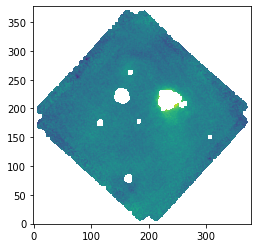

In [235]:
mask_3sigma = make_source_mask(data_ma-bkg, nsigma=3, npixels=3,
                               dilate_size=3, filter_fwhm=3)

data_ma2 = np.ma.masked_array(data, mask=mask_3sigma)

plt.imshow(data_ma2,origin='lower')
plt.show()

In [236]:
#create updated background model detected sources masked
bkg_data = Background2D(data_ma2,(bkgbox,bkgbox),bkg_estimator=bkg_estimator,edge_method='pad')
bkg_rms=bkg_data.background_rms 
bkg=bkg_data.background

#create background subtracted image
data_bkgsub = data - bkg

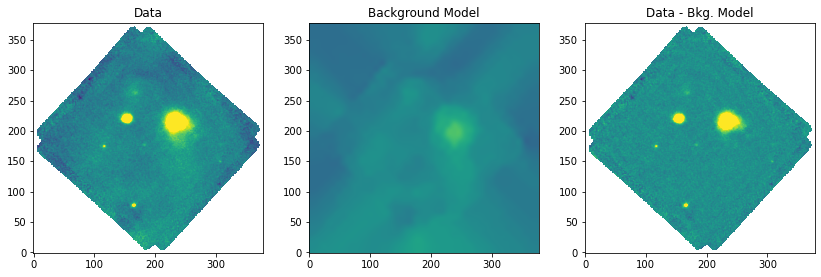

In [237]:
#plot the data and background model
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(14,10))
ax1.set_title('Data')

#set the image limits for the plots
minval=-0.1
maxval=0.1

ax1.imshow(data,origin='lower',vmin=minval,vmax=maxval)
ax2.set_title('Background Model')
ax2.imshow(bkg,origin='lower',vmin=minval,vmax=maxval)
ax3.set_title('Data - Bkg. Model')
ax3.imshow(data_bkgsub,origin='lower',vmin=minval,vmax=maxval)
plt.show()

## Do Photometry - Combined source list

In [238]:
#load in source lists if they exist
if os.path.isfile(field.name+'_'+str(wavelength)+'um_CombinedSources.fits'):
    combTab=Table.read(field.name+'_'+str(wavelength)+'um_CombinedSources.fits')
else:
    combTab=None
    
#Get Source coordinates from table
if combTab is not None:
    sourcesAll=combTab['sky_centroid']

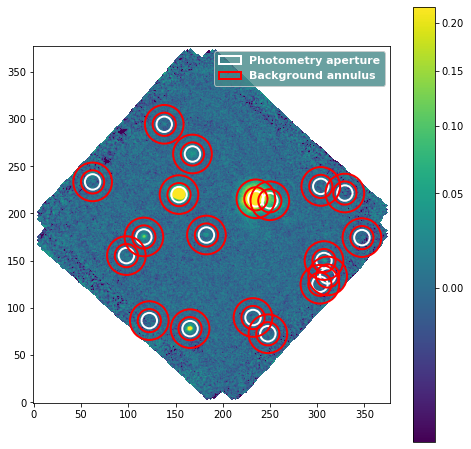

In [239]:
#radii = [4,5.5,8,10,12] #aperture radii to use in photoemtry - units are pixels
#r_in = 12  #inner radius for background annulus - units are pixels
#r_out = 20  #outer radius for background annulus - units are pixels

if combTab is not None:
    CombPhotTable=performApPhoto(data_bkgsub,errormap,tmap,header,sourcesAll,radii,r_in,r_out,plot=True)
    
    #add additonal information to table
    CombPhotTable['Field']=field.name
    CombPhotTable['wv']=wavelength

    #display the photometry table
    #CombPhotTable
else:
    print('No sources found in Combined Source List')

In [240]:
#merge Tables
mtComb = join(combTab, CombPhotTable, keys='id')

#add shape parameters to table
mtComb=fitshapes(data_bkgsub,mtComb,cutouts=True,cutsize=cutsize) #optional plot=True for diagnostic plots

#show table - optional
mtComb

sky_centroid,finder,id,xcentroid,ycentroid,sky_center,aperture_sum_4pix,aperture_sum_err_4pix,aperture_sum_8pix,aperture_sum_err_8pix,aperture_sum_12pix,aperture_sum_err_12pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,texp_med,texp_mean,aper_sum_bkgsub_4pix,aper_4pix_noise,aper_snr_4pix,aper_area_4pix,aper_sum_bkgsub_8pix,aper_8pix_noise,aper_snr_8pix,aper_area_8pix,aper_sum_bkgsub_12pix,aper_12pix_noise,aper_snr_12pix,aper_area_12pix,Field,wv,fit_x_cent,fit_y_cent,fwhm,semimajor_sigma,semiminor_sigma,orientation,elongation,covar_sigx2,covar_sigy2,fit_dist,"cutouts [25,25]"
"deg,deg",,,pix,pix,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,pix,pix,pix,deg,,pix2,pix2,,
object,int32,int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str7,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
"266.6342787101789,-28.68465238196559",110,1,165.39531476023,78.10439864202165,"266.6342787101789,-28.68465238196559",6.044002216556551,0.09320098617485158,7.910956136607504,0.1910400393261135,7.397011555910977,0.29177456731930007,842.3889608899609,-0.001077420289743941,-0.002085943419915937,0.007628658927304203,217.0907745361328,215.84478565848832,6.100727651451499,0.108638405453798,56.1562702063593,52.64931005562256,8.137857876187292,0.19952032026880528,40.787113138268325,210.59724022249023,7.907540469965504,0.29821664858419766,26.516093274829057,473.84379050060295,Field10,25,6.184133317793655,6.140409789731909,4.087540498630643,1.9197171731508007,1.5299733953326133,26.881609517021406,1.2547389248774863,3.410447780358544,2.6156848349571624,0.47861976583577714,-0.01772803207106693 .. -0.004423814460652831
"266.5998076805973,-28.669272686100275",110,2,307.1629947804721,150.18765066497156,"266.5998076805973,-28.669272686100275",0.6585391442039125,0.10842299230233009,0.5201593162427338,0.21169049360124806,0.21465512369310952,0.31303977953934004,842.3889608899609,-0.00021253343400406965,-0.0008366808698920112,0.007060689863442849,162.81808471679688,164.43383794908576,0.6697288828679788,0.1608971952021,4.162464622374211,52.64931005562256,0.5649182708989996,0.3325498053638424,1.6987478620861713,210.59724022249023,0.3153627716697076,0.744642724298131,0.42350883367181935,473.84379050060295,Field10,25,5.091826618750799,7.008328608235018,5.8876326564508785,2.8636098862897637,2.07417751834258,-53.46703919216432,1.380600195000666,5.6835421750264015,6.818931783427857,1.4971139721507367,-0.002494381190562965 .. -0.0053965862240625915
"266.6461616094202,-28.66394832858212",110,3,116.51270579742456,175.14830324405233,"266.6461616094202,-28.66394832858212",2.1893444072903225,0.09433440042569091,3.1633391951407823,0.188471984667572,2.99485555431757,0.2824314346473035,842.3889608899609,1.0579377096495016e-05,0.00032914702918335166,0.006489233028450234,217.0907745361328,216.72210779485,2.1887874103853737,0.11287742804935026,19.390833474947986,52.64931005562256,3.1611112075209875,0.20043695952706203,15.77109937697987,210.59724022249023,2.9898425821730314,0.2949379396213007,10.13719220393273,473.84379050060295,Field10,25,6.188557826966107,6.080635609458649,4.661146867589808,2.060080371629553,1.8953025130924137,37.60580718005497,1.0869401361518192,4.001232110517672,3.8348706431901043,0.5223626318930102,-0.009396239878336713 .. -0.0030359822713508233
"266.63006277133593,-28.66351199396784",310,4,182.72775275946896,177.20106113937183,"266.63006277133593,-28.66351199396784",0.875105006339967,0.0905261034021381,0.9756457118012247,0.18071993682940818,1.2571510700484647,0.2709916256627222,842.3889608899609,-0.0010711688647528543,-0.0014595612128896554,0.0063081914226048846,217.0907745361328,216.83696267408746,0.9315013080222692,0.12555518553348965,7.419058831097083,52.64931005562256,1.2012309185304337,0.21612033553454357,5.558157752991435,210.59724022249023,1.7647177

In [241]:
#write out catalog - May want some additional pre-processing before we get here but go ahead and print for now...
mtComb.write(field.name+'_'+str(wavelength)+'um_CombCat.fits', overwrite=True)

## Model fitting for point sources

In [242]:
from astropy.modeling import models, fitting
import warnings
from astropy.utils.exceptions import AstropyUserWarning

In [243]:
def extractModel(psfmodel, datacutout, unccutout,correctErrors=True):
	#Normalize psfmodel
	psfmodel = psfmodel / np.sum(psfmodel)
	
	#Compute best-fit flux for model
	model_flux = np.sum(psfmodel * datacutout) / np.sum(np.square(psfmodel))
	
	#Compute chi2 of model fit
	deg_freedom = np.size(datacutout) - 1 
	chi2 = np.sum(np.square(datacutout - psfmodel * model_flux) / np.square(unccutout)) / deg_freedom #*100
	
	
	if (correctErrors and chi2<2.0):
		re_unccutout=unccutout*np.sqrt(chi2)
		model_flux_err = np.sqrt(np.sum(np.square(psfmodel) * np.square(re_unccutout)))/ np.sum(np.square(psfmodel))
		#chi2 = np.sum(np.square(datacutout - psfmodel * model_flux) / np.square(re_unccutout)) / deg_freedom    
	else:
		model_flux_err = np.sqrt(np.sum(np.square(psfmodel) * np.square(unccutout)))/ np.sum(np.square(psfmodel))
	    
	return model_flux, model_flux_err, chi2

In [289]:
def modelSources(data,errorimg,tab,header,cutouts=False,cutsize=25):
    csize=17
    xfit=[]
    yfit=[]
    xfiterr=[]
    yfiterr=[]
    amp=[]
    alpha=[]
    alphaerr=[]
    gamma=[]
    gammaerr=[]
    fwhm=[]
    xfwhm=[]
    yfwhm=[]
    elong=[]
    orient=[]
    modelflux=[]
    modelfluxerr=[]
    modelSNRs=[]
    modelchi2=[]
    fitwarn=[]
    gmodelflux=[]
    gmodelfluxerr=[]
    gmodelSNRs=[]
    gmodelchi2=[]
    gfitwarn=[]
    modeltype=[]
    #sourcepixels=[]
    cimages=np.zeros((len(tab),csize,csize))
    residuals=np.zeros((len(tab),csize,csize))
    cutimgs=np.zeros((len(tab),cutsize,cutsize)) #these are the display cutouts
    pcovmatrix=[]
    
    
    i=0
    for source in tab:
        spos=(source['xcentroid'].value,source['ycentroid'].value)
        
        cut_img=Cutout2D(data,spos,csize,mode='partial',fill_value=0.0,copy=True)
        unc_img=Cutout2D(errorimg,spos,csize,mode='partial',fill_value=0.0,copy=True)
        
        cimg=cut_img.data
        uimg=unc_img.data
        
        #Background subtraction based on annulus background
        cimg=cimg-tab['ann_bkg_med'][i] #could do this better with a 2D bkg model... but larger cutout needed.
        
        y, x = np.mgrid[:csize, :csize]
        
        # Fit the data using astropy.modeling
        p1_init = models.Moffat2D(x_0=np.int32(csize/2),y_0=np.int32(csize/2))
        fit_p1 = fitting.LevMarLSQFitter(calc_uncertainties=True)
        
        
        with warnings.catch_warnings(record=True) as w:      
            
            p1 = fit_p1(p1_init, x, y, cimg)
            #print(w[0].message) #debugging to check error messages
            fitwarn.append(len(w))
            

        if p1.cov_matrix is not None:
            p1cov=np.diag(p1.cov_matrix.cov_matrix)
            xfiterr.append(p1cov[1])
            yfiterr.append(p1cov[2])
            gammaerr.append(p1cov[3])
            alphaerr.append(p1cov[4])
            #pcovmatrix.append(p1cov)
            #print(p1cov)
        else:
            xfiterr.append(-1)
            yfiterr.append(-1)
            gammaerr.append(-1)
            alphaerr.append(-1)
            #pcovmatrix.append([-1, -1, -1, -1, -1)
        
        mmodel=p1(x, y)
        resid=cimg.data - mmodel
        
        mflux,mfluxerr,chi2m=extractModel(mmodel,cimg,uimg)
        
        
        r_effective=(p1.fwhm)/2.0
        noisecalc=np.sqrt(2*np.pi*(r_effective*tab['ann_bkg_std'][i]/mflux)**2+(header['ERRCALF']/header['CALFCTR'])**2+0.0025+(mfluxerr/mflux)**2)
        modelSNR=mflux/noisecalc
        
        
        p2_init = models.Gaussian2D(x_mean=np.int32(csize/2),y_mean=np.int32(csize/2))
        fit_p2 = fitting.LevMarLSQFitter(calc_uncertainties=True)
        
        with warnings.catch_warnings(record=True) as w2:
            p2 = fit_p2(p2_init, x, y, cimg)
            
            gfitwarn.append(len(w2))
        
        gmodel=p2(x, y)
        gresid=cimg - gmodel
        
        gflux,gfluxerr,chi2g=extractModel(gmodel,cimg,uimg)
        
        
        r_effective=np.sqrt(p2.x_fwhm*p2.y_fwhm)/2.0
        noisecalc=np.sqrt(2*np.pi*(r_effective*tab['ann_bkg_std'][i]/gflux)**2+(header['ERRCALF']/header['CALFCTR'])**2+0.0025+(gfluxerr/gflux)**2)
        gmodelSNR=gflux/noisecalc
        
        if cutouts:
            c2=Cutout2D(data,spos,cutsize,mode='partial',fill_value=0.0,copy=True)
            cutimgs[i,:,:]=c2
            
                
        #pix_aperture=CircularAperture((p1.x_0.value,p1.y_0.value), r=r_effective*1.2)
        #source_mask = pix_aperture.to_mask(method='exact')
        #source_data = source_mask.multiply(data)
        #sourcedata=source_mask.data
        #ourcepix=sum(sum(sourcedata>5*tab['ann_bkg_std'][i]))
 

        xfit.append(p1.x_0.value)
        yfit.append(p1.y_0.value)
        amp.append(p1.amplitude.value)
        alpha.append(p1.alpha.value)
        gamma.append(p1.gamma.value)
        fwhm.append(p1.fwhm*0.768) # in arcseconds
        xfwhm.append(p2.x_fwhm*0.768) # in arcseconds
        yfwhm.append(p2.y_fwhm*0.768) # in arcseconds
        
        if p2.x_fwhm<p2.y_fwhm:
            elong.append(p2.x_fwhm/p2.y_fwhm)
        else:
            elong.append(p2.y_fwhm/p2.x_fwhm)
        
        orient.append(p2.theta.value)
        modelflux.append(mflux)
        modelfluxerr.append(mfluxerr)
        modelSNRs.append(modelSNR)
        modelchi2.append(chi2m)
        
        gmodelflux.append(gflux)
        gmodelfluxerr.append(gfluxerr)
        gmodelSNRs.append(gmodelSNR)
        gmodelchi2.append(chi2g)
        #sourcepixels.append(sourcepix)
        i=i+1
         

    #elongation
    tab['fit_x0']=xfit
    tab['fit_y0']=yfit
    tab['fit_x0_err']=xfiterr
    tab['fit_y0_err']=yfiterr
    tab['fit_amp']=amp
    tab['fit_gamma']=gamma
    tab['fit_gamma_err']=gammaerr
    tab['fit_alpha']=alpha
    tab['fit_alpha_err']=alphaerr
    tab['fit_fwhm']=fwhm
    tab['fit_xfwhm']=xfwhm
    tab['fit_yfwhm']=yfwhm
    tab['fit_elong']=elong
    tab['fit_orient']=orient
    tab['FluxMoffat2D']=modelflux
    tab['FluxMoffatErr']=modelfluxerr
    tab['ModelSNR']=modelSNRs
    tab['Moffat2DChi2']=modelchi2
    tab['FluxGauss2D']=gmodelflux
    tab['FluxGauss2DErr']=gmodelfluxerr
    tab['gModelSNR']=gmodelSNRs
    tab['Gauss2DChi2']=gmodelchi2
    tab['FitWarningFlag']=fitwarn
    #tab['SourcePix']=sourcepixels
    #tab['DataCutout']=cimages
    #tab['ModelResidual']=residuals
    tab['cutouts']=cutimgs
    #tab['Model_pcov']=pcovmatrix
    
    scstats=sigma_clipped_stats(modelchi2)
    rescl=scstats[1]+3*scstats[2]
    if rescl<0.7:
        tab['MoffatChi2RE']=np.array(modelchi2)/rescl
    else:
        tab['MoffatChi2RE']=np.array(modelchi2)
    
    scstats=sigma_clipped_stats(gmodelchi2)
    rescl=scstats[1]+3*scstats[2]
    if rescl<0.7:
        tab['GaussChi2RE']=np.array(gmodelchi2)/rescl
    else:
        tab['GaussChi2RE']=np.array(gmodelchi2)
    
    #classify models
    for source in tab:
        if source['MoffatChi2RE']<=2.0:
            mtype='M'
            #residuals[i,:,:]=resid
        elif source['GaussChi2RE']<=2.0:
            mtype='G'
            #residuals[i,:,:]=gresid
        else:
            mtype='A' 
                
        modeltype.append(mtype)
        
    tab['BestModel']=modeltype
    
    return tab

In [290]:
newtab=modelSources(data_bkgsub,errormap,mtComb,header)

C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\modeling\functional_models.py:2434: RuntimeWarning: invalid value encountered in sqrt
  return 2.0 * np.abs(self.gamma) * np.sqrt(2.0 ** (1.0 / self.alpha) - 1.0)
C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\modeling\functional_models.py:2434: RuntimeWarning: invalid value encountered in sqrt
  return 2.0 * np.abs(self.gamma) * np.sqrt(2.0 ** (1.0 / self.alpha) - 1.0)


In [291]:
newtab

sky_centroid,finder,id,xcentroid,ycentroid,sky_center,aperture_sum_4pix,aperture_sum_err_4pix,aperture_sum_8pix,aperture_sum_err_8pix,aperture_sum_12pix,aperture_sum_err_12pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,texp_med,texp_mean,aper_sum_bkgsub_4pix,aper_4pix_noise,aper_snr_4pix,aper_area_4pix,aper_sum_bkgsub_8pix,aper_8pix_noise,aper_snr_8pix,aper_area_8pix,aper_sum_bkgsub_12pix,aper_12pix_noise,aper_snr_12pix,aper_area_12pix,Field,wv,fit_x_cent,fit_y_cent,fwhm,semimajor_sigma,semiminor_sigma,orientation,elongation,covar_sigx2,covar_sigy2,fit_dist,"cutouts [25,25]",fit_x0,fit_y0,fit_x0_err,fit_y0_err,fit_amp,fit_gamma,fit_gamma_err,fit_alpha,fit_alpha_err,fit_fwhm,fit_xfwhm,fit_yfwhm,fit_elong,fit_orient,FluxMoffat2D,FluxMoffatErr,ModelSNR,Moffat2DChi2,FluxGauss2D,FluxGauss2DErr,gModelSNR,Gauss2DChi2,FitWarningFlag,MoffatChi2RE,GaussChi2RE,BestModel
"deg,deg",,,pix,pix,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,pix,pix,pix,deg,,pix2,pix2,,,,,,,,,,,,,,,,,,,,,,,,,,,,
object,int32,int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str7,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,str1
"266.6342787101789,-28.68465238196559",110,1,165.39531476023,78.10439864202165,"266.6342787101789,-28.68465238196559",6.044002216556551,0.09320098617485158,7.910956136607504,0.1910400393261135,7.397011555910977,0.29177456731930007,842.3889608899609,-0.001077420289743941,-0.002085943419915937,0.007628658927304203,217.0907745361328,215.84478565848832,6.100727651451499,0.108638405453798,56.1562702063593,52.64931005562256,8.137857876187292,0.19952032026880528,40.787113138268325,210.59724022249023,7.907540469965504,0.29821664858419766,26.516093274829057,473.84379050060295,Field10,25,6.184133317793655,6.140409789731909,4.087540498630643,1.9197171731508007,1.5299733953326133,26.881609517021406,1.2547389248774863,3.410447780358544,2.6156848349571624,0.47861976583577714,0.0 .. 0.0,8.370030324003038,8.127303773275239,0.015228373214019071,0.015248940762436707,0.3915868068134616,2.699194310142156,0.5519077183104187,1.9992586621028021,0.4177313695973704,2.668902969730168,2.9507630995483782,3.4878313557020117,0.8460165640532997,1.8547479421176827,8.28637832330495,0.08174563561956466,149.50242280736413,0.6911378211838214,6.7495049094116055,0.08307267244077525,120.35073114008947,1.0604668848129026,0,1.3277863345086016,1.9661150497394537,M
"266.5998076805973,-28.669272686100275",110,2,307.1629947804721,150.18765066497156,"266.5998076805973,-28.669272686100275",0.6585391442039125,0.10842299230233009,0.5201593162427338,0.21169049360124806,0.21465512369310952,0.31303977953934004,842.3889608899609,-0.00021253343400406965,-0.0008366808698920112,0.007060689863442849,162.81808471679688,164.43383794908576,0.6697288828679788,0.1608971952021,4.162464622374211,52.64931005562256,0.5649182708989996,0.3325498053638424,1.6987478620861713,210.59724022249023,0.3153627716697076,0.744642724298131,0.42350883367181935,473.84379050060295,Field10,25,5.091826618750799,7.008328608235018,5.8876326564508785,2.8636098862897637,2.07417751834258,-53.46703919216432,1.380600195000666,5.6835421750264015,6.818931783427857,1.4971139721507367,0.0 .. 0.0,8.073829847542216,8.172518608357043,-1.0,-1.0,0.05080411831249277,214.7211570226979,-1.0,10336.220606090206,-1.0,2.7008793284428934,3.1115119665289916,2.2888609123323502,0.7356105124948822,-0.7323889256323761,0.7119625858878134,0.045072840000231026,7.556451169863231,0.3245347680344737,0.7123129340156023,0.04401465420068437,7.6630961384383465,0.3170213065749006,1,0.6234832140006465,0.5877603260142777,M
"266.6461616094202,-28.663948328

(array([16.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0.21061576,  2.76367139,  5.31672701,  7.86978264, 10.42283826,
        12.97589389, 15.52894951, 18.08200513, 20.63506076, 23.18811638,
        25.74117201]),
 <BarContainer object of 10 artists>)

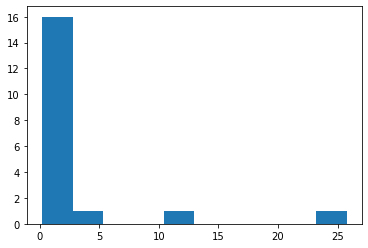

In [292]:
plt.hist(newtab['Moffat2DChi2'])

In [293]:
sigma_clipped_stats(newtab['Moffat2DChi2'])

(0.333659946909786, 0.3455161318848357, 0.05833424070217865)

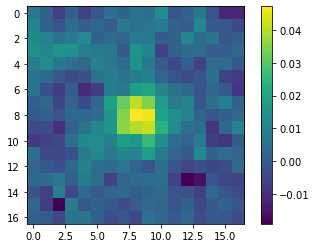

In [211]:
plt.imshow(newtab['DataCutout'][1])
plt.colorbar()

## Testing...

In [422]:
mtComb

sky_centroid,finder,id,xcentroid,ycentroid,sky_center,aperture_sum_5.5pix,aperture_sum_err_5.5pix,aperture_sum_10.5pix,aperture_sum_err_10.5pix,aperture_sum_14pix,aperture_sum_err_14pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,texp_med,texp_mean,aper_sum_bkgsub_5.5pix,aper_5.5pix_noise,aper_snr_5.5pix,aper_area_5.5pix,aper_sum_bkgsub_10.5pix,aper_10.5pix_noise,aper_snr_10.5pix,aper_area_10.5pix,aper_sum_bkgsub_14pix,aper_14pix_noise,aper_snr_14pix,aper_area_14pix,Field,wv,fit_x_cent,fit_y_cent,fwhm,semimajor_sigma,semiminor_sigma,orientation,elongation,covar_sigx2,covar_sigy2,fit_dist,"cutouts [25,25]",fit_x0,fit_y0,fit_x0_err,fit_y0_err,fit_amp,fit_gamma,fit_gamma_err,fit_alpha,fit_alpha_err,fit_fwhm,fit_xfwhm,fit_yfwhm,fit_elong,fit_orient,FluxMoffat2D,FluxMoffatErr,Moffat2DChi2,ModelSNR,FitWarningFlag,"DataCutout [17,17]","ModelResidual [17,17]"
"deg,deg",,,pix,pix,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,pix,pix,pix,deg,,pix2,pix2,,,,,,,,,,,,,,,,,,,,,,,
object,int32,int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str7,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64
"266.7426755215877,-28.55271259391249",210,1,169.6482538815153,83.68759848350857,"266.7426755215877,-28.55271259391249",5.212105365104701,0.18552490100609545,11.499306394985451,0.3541185523982983,16.53450557804905,0.47215705268210895,947.6873163053789,0.0013830199141467159,0.00486877635457468,0.019171896496422335,531.87744140625,531.747101145497,5.074439460477109,0.20107561081021347,25.23647418018614,99.54007402165871,10.997565370681583,0.3616683742014528,30.40787128530025,362.78655077315284,15.642521534842171,0.4775783224689612,32.75383491858304,644.9538680411607,Field06,37,6.778103209253968,6.959622208935715,6.43430137045913,3.627463658465647,1.3317227649844061,-53.716424590469295,2.7238879996979874,5.760584252708148,9.171393863558539,0.5372094283836636,0.0 .. 0.0,6.976743389731339,10.596608922811386,-1.0,-1.0,0.0697922042503726,242.22552911437464,-1.0,961.7102523635,-1.0,9.99033370321608,5.835676725769311,38.84356891965942,0.15023533851483384,-2.615249435635706,9.730101213880511,0.27947811132735934,1.669288929070342,-1.0,1,-0.024915429830193736 .. -0.01278907849306335,-0.029922221364909303 .. -0.024194970735116367
"266.7264348118568,-28.54406485554776",110,2,236.52527792123487,124.21587682747598,"266.7264348118568,-28.54406485554776",15.765869581337721,0.18459742931148007,25.392521671991624,0.35263189848514764,27.573437431570735,0.470242361228774,947.6873163053789,-0.0004441355303847912,-0.0010724384968402094,0.010059360912668977,531.87744140625,531.7924914304929,15.810078864907872,0.19352521485987148,81.69518828001662,99.54007402165871,25.553648069135726,0.3574289537942515,71.49294369656828,362.78655077315284,27.859884359826918,0.4739064089948107,58.787734943107694,644.9538680411607,Field06,37,6.462179028321628,6.17661473626274,4.640630087762068,2.114126733599593,1.8159677922164774,-12.174928825082395,1.1641873510428276,4.417413336670418,3.349857531417653,0.32558939586711544,0.0 .. 0.0,7.45854759852505,8.171657374308213,0.031693786606618646,0.031653611725851294,0.32812723600220045,4.887759680513989,1.7166525140544497,1.67272690187297,0.2850571566544582,5.379520610587417,7.050501375306275,6.127606522523133,1.1506126167518873,-0.280392109464467,23.746413914331388,0.2400380676541516,0.4903746836432082,480.78995995563383,0,0.009257072176813244 .. 0.009785085910358234,-0.0065766969251936005 .. -0.004116974135190471
"266.7219013399001,-28.533279587252657",110,3,255.20428897567257,174.76797546098695,"266.7219013399001,-28.533279587252657",27.88499240089919,0.18597940204210453,69.4395

In [439]:
testsource=mtComb[-1]
csize=21

In [440]:
testsource

sky_centroid,finder,id,xcentroid,ycentroid,sky_center,aperture_sum_5.5pix,aperture_sum_err_5.5pix,aperture_sum_10.5pix,aperture_sum_err_10.5pix,aperture_sum_14pix,aperture_sum_err_14pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,texp_med,texp_mean,aper_sum_bkgsub_5.5pix,aper_5.5pix_noise,aper_snr_5.5pix,aper_area_5.5pix,aper_sum_bkgsub_10.5pix,aper_10.5pix_noise,aper_snr_10.5pix,aper_area_10.5pix,aper_sum_bkgsub_14pix,aper_14pix_noise,aper_snr_14pix,aper_area_14pix,Field,wv,fit_x_cent,fit_y_cent,fwhm,semimajor_sigma,semiminor_sigma,orientation,elongation,covar_sigx2,covar_sigy2,fit_dist,"cutouts [25,25]",fit_x0,fit_y0,fit_x0_err,fit_y0_err,fit_amp,fit_gamma,fit_gamma_err,fit_alpha,fit_alpha_err,fit_fwhm,fit_xfwhm,fit_yfwhm,fit_elong,fit_orient,FluxMoffat2D,FluxMoffatErr,Moffat2DChi2,ModelSNR,FitWarningFlag,"DataCutout [17,17]","ModelResidual [17,17]"
"deg,deg",,,pix,pix,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,pix,pix,pix,deg,,pix2,pix2,,,,,,,,,,,,,,,,,,,,,,,
object,int32,int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str7,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64
"266.75628993587696,-28.520297548954613",10,22,113.58294989577257,235.63284942768144,"266.75628993587696,-28.520297548954613",29.838879119220312,0.1891418371215322,94.21385184363018,0.36101883404322377,141.52235104695927,0.48138192402393065,947.6873163053789,0.05529685527644165,0.06251434712681178,0.04557825296641005,531.87744140625,531.7807680124208,24.33462605183836,0.19934956854442146,122.07012149321922,99.54007402165871,74.1528964492877,0.3659168760719636,202.64956687787284,362.78655077315284,105.85843034590596,0.48503165585943414,218.250559663645,644.9538680411607,Field06,37,9.794777917388815,4.899166881345843,5.352880033536101,2.698744676390929,1.746791205975304,-77.12983593610859,1.5449726716961065,3.261244076410451,7.073258269210585,3.663089979606422,0.0 .. 0.0,12.765021877364264,5.6144739087303135,0.48525260958428135,0.347301565755447,0.3689117381040946,3.7644515890157737,4.253320952491778,0.3530049542292145,0.017380344265148322,14.309813403151917,26.203843810932057,13.064802899524382,2.0056822909962153,-3.759044876937426,62.79518088697337,0.31089592336738014,1.752807248147054,992.1453459270109,0,0.11420377500541118 .. 0.09875660391127142,-0.028559119925058662 .. -0.06882497307567734


In [441]:
spos=(testsource['xcentroid'].value,testsource['ycentroid'].value)
y, x = np.mgrid[:csize, :csize]

In [442]:
cimg=Cutout2D(data_bkgsub,spos,csize,mode='partial',fill_value=0.0,copy=True)
uimg=Cutout2D(errormap,spos,csize,mode='partial',fill_value=0.0,copy=True)

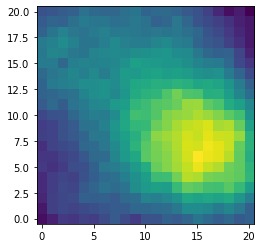

In [443]:
plt.imshow(cimg.data, origin='lower', cmap='viridis',interpolation=None)
plt.show()

In [444]:
# Fit the data using astropy.modeling
#p_init = models.Gaussian2D(x_mean=15,y_mean=15)
p_init = models.Moffat2D(x_0=np.int32(csize/2),y_0=np.int32(csize/2))
fit_p = fitting.LevMarLSQFitter(calc_uncertainties=True)

In [445]:
p = fit_p(p_init, x, y, cimg.data)
fit_p.fit_info['message']

'Both actual and predicted relative reductions in the sum of squares\n  are at most 0.000000'

In [446]:
p

<Moffat2D(amplitude=0.43003623, x_0=14.35444232, y_0=7.86557135, gamma=3.41051785, alpha=0.29524261)>

In [447]:
p.cov_matrix

parameter variances / covariances 
amplitude| 0.003
x_0      | 0.   , 0.506
y_0      | -0.   , -0.021,  0.44 
gamma    | -0.092, -0.096,  0.068,  4.159
alpha    | -0.003, -0.011,  0.006,  0.19 ,  0.01

In [448]:
modelim=p(x, y)
resid=cimg.data - modelim

Text(0.5, 1.0, 'Residual')

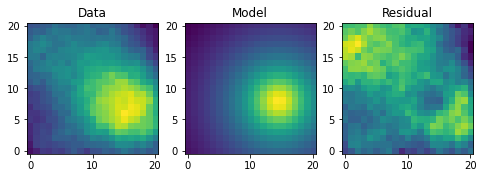

In [449]:
plt.figure(figsize=(8, 2.5))
plt.subplot(1, 3, 1)
plt.imshow(cimg.data, origin='lower', interpolation='nearest')#, vmin=-0.05, vmax=0.05)
plt.title("Data")
plt.subplot(1, 3, 2)
plt.imshow(modelim, origin='lower', interpolation='nearest')#, vmin=-0.05, vmax=0.05)
plt.title("Model")
plt.subplot(1, 3, 3)
plt.imshow(resid, origin='lower', interpolation='nearest')#, vmin=-0.05, vmax=0.05)
plt.title("Residual")

In [450]:
mflux,mfluxerr,chi=extractModel(modelim,cimg.data,uimg.data)
mflux

109.55402716257707

In [451]:
mean,med,std=sigma_clipped_stats(resid)
sourcepix=sum(sum(modelim>4*std))
noise=3*std*sourcepix
roughSNR=mflux/noise
roughSNR

2.5658566783281067

In [452]:
sourcepix

441

In [453]:
chi

2.9084539326328436

In [454]:
p.fwhm

20.981418600093235

## Old...

In [455]:
def fitshapes2(image,tab,plot=False):
    columns = ['xcentroid', 'ycentroid','fwhm' ,'semimajor_sigma','semiminor_sigma', 'orientation','covar_sigx2','covar_sigy2']
    
    #initialize table with correct column formatting by creating dummy table
    from photutils.datasets import make_4gaussians_image
    data = make_4gaussians_image()[43:79, 76:104]
    cat = data_properties(data)
    tbl = cat.to_table(columns=columns)
    tbl.remove_row(0) #remove entry from dummy table
    
    #fix keywords in table if they don't match what is expected
    if 'xcentroid' not in tab.columns:
        tab.rename_column('xcenter', 'xcentroid')
        tab.rename_column('ycenter', 'ycentroid')
    
    #loop through sources and fit shapes
    for source in tab:
        #create data cutout around source centroid position
        spos=(np.int64(source['xcentroid'])+1,np.int64(source['ycentroid'])+1)
        cutout=Cutout2D(image,spos,13,mode='partial',fill_value=0.0,copy=True)
        
        #do addtional bkg subtraciton here? - think not for now...
        mean, median, std = sigma_clipped_stats(cutout.data, sigma=3.0)
        c1 = cutout.data - median
        
        #get shape fitting results and store to table
        cat = data_properties(c1,background=std)
        temp = cat.to_table(columns=columns)
        tbl=vstack([tbl,temp])

        #optional plots for visual diagnostics
        if plot==True:
            position = (cat.xcentroid, cat.ycentroid)
            r = 1.0  # approximate isophotal extent
            a = cat.semimajor_sigma.value * r
            b = cat.semiminor_sigma.value * r
            theta = cat.orientation.to(u.rad).value
            apertures = EllipticalAperture(position, a, b, theta=theta)
            plt.imshow(c1, origin='lower', cmap='viridis',interpolation=None)
            apertures.plot(color='r')
            plt.show()
            
    tbl['fit_dist']=np.sqrt((tbl['xcentroid']-10.5)**2+(tbl['ycentroid']-10.5)**2)
            
    return tbl 
    
    #if needed, rename duplicate columns from seg table
    #if 'fwhm' in tab.columns:
    #    tab.rename_column('fwhm', 'fwhm_seg')
    #    print('this already has FWHM column!')
    #if 'semimajor_sigma' in tab.columns:
    #    tab.rename_column('semimajor_sigma', 'semimajor_sigma_seg')
    #if 'semiminor_sigma' in tab.columns:
    #    tab.rename_column('semiminor_sigma', 'semiminor_sigma_seg')        
    #if 'orientation' in tab.columns:
    #    tab.rename_column('orientation', 'orientation_seg')        
        
    #add fitted shape parameters to table
    #tab['fit_x_cent']=tbl['xcentroid']
    #tab['fit_y_cent']=tbl['ycentroid']        
    #tab['fwhm']=tbl['fwhm']    
    #tab['semimajor_sigma']=tbl['semimajor_sigma']
    #tab['semiminor_sigma']=tbl['semiminor_sigma']
    #tab['orientation']=tbl['orientation']

    #return input table with new columns from shape fitting
    #return tab


In [456]:
testsource=mtComb[0:2]

In [457]:
testsource

sky_centroid,finder,id,xcentroid,ycentroid,sky_center,aperture_sum_5.5pix,aperture_sum_err_5.5pix,aperture_sum_10.5pix,aperture_sum_err_10.5pix,aperture_sum_14pix,aperture_sum_err_14pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,texp_med,texp_mean,aper_sum_bkgsub_5.5pix,aper_5.5pix_noise,aper_snr_5.5pix,aper_area_5.5pix,aper_sum_bkgsub_10.5pix,aper_10.5pix_noise,aper_snr_10.5pix,aper_area_10.5pix,aper_sum_bkgsub_14pix,aper_14pix_noise,aper_snr_14pix,aper_area_14pix,Field,wv,fit_x_cent,fit_y_cent,fwhm,semimajor_sigma,semiminor_sigma,orientation,elongation,covar_sigx2,covar_sigy2,fit_dist,"cutouts [25,25]",fit_x0,fit_y0,fit_x0_err,fit_y0_err,fit_amp,fit_gamma,fit_gamma_err,fit_alpha,fit_alpha_err,fit_fwhm,fit_xfwhm,fit_yfwhm,fit_elong,fit_orient,FluxMoffat2D,FluxMoffatErr,Moffat2DChi2,ModelSNR,FitWarningFlag,"DataCutout [17,17]","ModelResidual [17,17]"
"deg,deg",,,pix,pix,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,pix,pix,pix,deg,,pix2,pix2,,,,,,,,,,,,,,,,,,,,,,,
object,int32,int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str7,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64
"266.7426755215877,-28.55271259391249",210,1,169.6482538815153,83.68759848350857,"266.7426755215877,-28.55271259391249",5.212105365104701,0.18552490100609545,11.499306394985451,0.3541185523982983,16.53450557804905,0.47215705268210895,947.6873163053789,0.0013830199141467159,0.00486877635457468,0.019171896496422335,531.87744140625,531.747101145497,5.074439460477109,0.20107561081021347,25.23647418018614,99.54007402165871,10.997565370681583,0.3616683742014528,30.40787128530025,362.78655077315284,15.642521534842171,0.4775783224689612,32.75383491858304,644.9538680411607,Field06,37,6.778103209253968,6.959622208935715,6.43430137045913,3.627463658465647,1.3317227649844061,-53.716424590469295,2.7238879996979874,5.760584252708148,9.171393863558539,0.5372094283836636,0.0 .. 0.0,6.976743389731339,10.596608922811386,-1.0,-1.0,0.0697922042503726,242.22552911437464,-1.0,961.7102523635,-1.0,9.99033370321608,5.835676725769311,38.84356891965942,0.15023533851483384,-2.615249435635706,9.730101213880511,0.27947811132735934,1.669288929070342,-1.0,1,-0.024915429830193736 .. -0.01278907849306335,-0.029922221364909303 .. -0.024194970735116367
"266.7264348118568,-28.54406485554776",110,2,236.52527792123487,124.21587682747598,"266.7264348118568,-28.54406485554776",15.765869581337721,0.18459742931148007,25.392521671991624,0.35263189848514764,27.573437431570735,0.470242361228774,947.6873163053789,-0.0004441355303847912,-0.0010724384968402094,0.010059360912668977,531.87744140625,531.7924914304929,15.810078864907872,0.19352521485987148,81.69518828001662,99.54007402165871,25.553648069135726,0.3574289537942515,71.49294369656828,362.78655077315284,27.859884359826918,0.4739064089948107,58.787734943107694,644.9538680411607,Field06,37,6.462179028321628,6.17661473626274,4.640630087762068,2.114126733599593,1.8159677922164774,-12.174928825082395,1.1641873510428276,4.417413336670418,3.349857531417653,0.32558939586711544,0.0 .. 0.0,7.45854759852505,8.171657374308213,0.031693786606618646,0.031653611725851294,0.32812723600220045,4.887759680513989,1.7166525140544497,1.67272690187297,0.2850571566544582,5.379520610587417,7.050501375306275,6.127606522523133,1.1506126167518873,-0.280392109464467,23.746413914331388,0.2400380676541516,0.4903746836432082,480.78995995563383,0,0.009257072176813244 .. 0.009785085910358234,-0.0065766969251936005 .. -0.004116974135190471


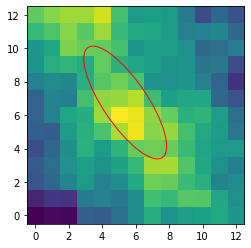

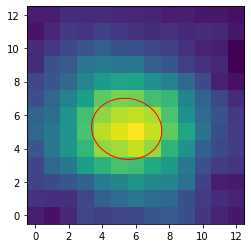

In [458]:
#newest examine
rtab=fitshapes2(data_bkgsub,testsource,plot=True)

## Other Testing For Radial Profile Plot

In [886]:
#radii=[1,2,3,4,5,6,7,8,9,10]
radii=np.linspace(0.5,10.5,20)
res=1.0

ap=CircularAperture(sc,0.5)
ap_mask=ap.to_mask(method='subpixel')
ap_arr=ap_mask.multiply(data)
ap_arr[ap_arr==0]=np.nan
cval=np.nanmax(ap_arr)


means=[cval]
meds=[cval]
stds=[cval*0.3]

for r in radii:
    an_ap = CircularAnnulus(sc, r_in=r, r_out=r+res)
    an_mask=an_ap.to_mask(method='subpixel')
    an_arr=an_mask.multiply(data)
    an_arr[an_arr==0]=np.nan
    mean,med,std=sigma_clipped_stats(an_arr)
    means.append(mean)
    #means.append(np.nanmean(an_arr))
    #meds.append(np.nanmedian(an_arr))
    #stds.append(np.nanstd(an_arr))
    
#radii.insert(0,0)
radii=np.insert(radii,0,0)

NameError: name 'sc' is not defined

In [ ]:
ap_arr

In [ ]:
#plt.errorbar(radii,means,stds)
plt.plot(radii,means)

In [ ]:
means

In [ ]:
#bkg sub with cutout 17x17
rtab=fitshapes2(data_bkgsub,testsource,plot=True)

In [ ]:
rtab

In [ ]:
np.median(rtab['ycentroid'])

In [ ]:
#bkg sub with cutout 13x13
fitshapes2(data_bkgsub,testsource,plot=True)

In [ ]:
#bkg sub with cutout 9x9
fitshapes2(data_bkgsub,testsource,plot=True)

In [ ]:
#no bkg sub with cutout 9x9
fitshapes2(data_bkgsub,testsource,plot=True)

## Do Photometry - Only Segment Map Sources (optional)

In [ ]:
#get seg table from detection step
if os.path.isfile(field.name+'_'+str(wavelength)+'um_seg.fits'):
    segTab=Table.read(field.name+'_'+str(wavelength)+'um_seg.fits')
else:
    segTab=None

#Get Source coordinates from table
if segTab is not None:
    sourcesseg=segTab['sky_centroid']

In [ ]:
if segTab is not None:
    SegPhotTable=performApPhoto(data_bkgsub,tmap,wcsmap,sourcesseg,radii,r_in,r_out,plot=True)

    #display the photometry table
    #SegPhotTable
else:
    print('No sources found in segmentation map')

In [ ]:
#fix id keywords in Seg table so they can be merged
try:
    segTab.rename_column('label', 'id')
except:
    print('Do nothing because keyword is already changed.')

In [ ]:
#merge Tables
mtSeg = join(segTab, SegPhotTable, keys='id')

#add shape parameters to table
mtSeg=fitshapes(data_bkgsub,mtSeg) #optional plot=True for diagnostic plots

#display seg table
mtSeg

In [ ]:
#write out the resulting tables to file
mtSeg.write(field.name+'_'+str(wavelength)+'um_segCat.fits',overwrite=True)

## Do Photometry - Only DAO Sources (optional)

In [ ]:
if os.path.isfile(field.name+'_'+str(wavelength)+'um_dao.fits'):   
    daoTab=Table.read(field.name+'_'+str(wavelength)+'um_dao.fits')
else:
    daoTab=None
    
if daoTab is not None:
    sourcesdao=daoTab['sky_centroid']

In [ ]:
if daoTab is not None:
    DaoPhotTable=performApPhoto(data_bkgsub,tmap,wcsmap,sourcesdao,radii,r_in,r_out,plot=True)

    #display the photometry table
    #DaoPhotTable
else:
    print('No sources found by DAOfind map')

In [ ]:
#merge Tables
mtDao = join(daoTab, DaoPhotTable, keys='id')

#add shape parameters to table
mtDao=fitshapes(data_bkgsub,mtDao) #optional plot=True for diagnostic plots

#optional - show Dao table
#mtDao

In [ ]:
#write out the resulting tables to file
mtDao.write(field.name+'_'+str(wavelength)+'um_daoCat.fits',overwrite=True)